# Tutorial 1B: Experimentally Measuring *E. coli* Growth

© 2018 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [15]:
import numpy as np # For numerics
import pandas as pd # For loading and saving data
import glob # For parsing directories and files
import skimage.io # For basic image processing
import skimage.filters  
import matplotlib.pyplot as plt # For plotting
import seaborn as sns # For (nice) plotting
sns.set_context('talk')

# For rendering inline graphics for Python 3.6 and below
%matplotlib inline

In this tutorial, we will analyze a movie of growing *E. coli* cells using some rudimentary image processing and will estimate a doubling time.  

##  Using Microscopy to Measure Bacterial Growth

 While we have jsut scraped the surface of growth in class, there is a seemingly endless reservoir of literature that explores the fascinating physiology of cellular growth. For a detailed summary, see [this review](https://jun.ucsd.edu/files/publications/Jun_ROPP_2018.pdf) by Suckjoon Jun and colleagues which gives both a historical accounting of bacterial growth physiology and a view of the future of the field. 
 
As discussed in class and examined numerically in [tutorial 1A](t1a_numierical_integration.html), the early growth phase of a bacterial culture can be stated mathematically as 

$$
N(t) = N_0 e^{rt}, \tag{1}
$$

where $N(t)$ is the number of cells at time $t$, $N_0$ is the initial number of cells and $r$ is the growth rate in dimensions of time.   Experimentally, it's difficult to count the number of cells in a culture, but easy to measure other properites. In spectrophotometry, we measure the absorbance of a culture at a given wavelenght, most commonly 600 nm. We could then rephrase Eq. 1 in terms of absorbance as

$$
\text{Abs}(t) = \text{Abs}_0 e^{rt}, \tag{2}
$$

where $\text{Abs}_0$ is the the intial absorbance of the culture at time $t=0$. The point of this discussion is that there are many ways we can keep track of growth and estimate a growth rate in a manner that is easier than counting the number of cells. 

In this tutorial, we will use a movie of *E. coli* cells growing on a hard agar subtstrate at 100x magnification. While we could in principle count the number of cells by hand, we will determine the total area of bacteria in each image, from a movie much like this one:

<img src="ecoli.gif" style="width: 400px;">


## Some Basic Image Processing

While we often think of images as a colorful photograph, it is important to remembrer that at its core, a digital image is nothing but data. An image is a matrix of numbers upon which we can deploy mathematical operations. Before we begin, make sure you have downloaded the [data set](http://rpdata.caltech.edu/courses/course_data/ecoli_growth.zip), unzipped it, and placed it in your root `data` folder.

We'll start by loading these fluorescent images. In the downloaded data, each image has a unique name that gives us information about that image. There are two different types of images here $--$ one takin in phase contrast and one in fluorescence. The images are named something like the following:

`ecoli_phase_01.tif` and `ecoli_TRITC_01.tif`

Quite obviously, the first word tells us the organism (*E. coli*). The second term tells us the channel of the image (`phase` is phase contrast and `TRITC` is a fluorescent image of the Red Fluorescent Protein expressed by these cells). The final number, here `01` tells us the frame number. This is **not** the time, but just the number of this image in the complete sequence. 

In this data set, there should be 20 images of each channel. While we could create a list of all of these file names by hand, we can use the `glob` package in Python to get all of the file names and path for us, so long as we give it a pattern to follow.

In [82]:
# Use glob to get all of the TRITC images 
files = glob.glob('data/ecoli_growth/ecoli_TRITC_*.tif')

In the above code cell, we called a method called `glob` from the root module `glob` and fed it a string pattern. This is a string that gives just enough information for our computer to find all of the files, but gives it some leeway. In the string we passed to `glob`, we told it to look in the directory `data`, in the subdirectory `ecoli_growth` and for any file that began with `ecoli_TRITC_` and ended in `.tif`. The asterisk (`*`) is a so-called "wild card" character. This means that `glob.glob` will find all files that match this pattern, but can have *any* character inbetween `TRITC_` and `.tif`. Now that we've loaded the files, let's take a look at the first five file names. 

In [83]:
# Print the first five entries to the screen
files[:5]

['data/ecoli_growth/ecoli_TRITC_18.tif',
 'data/ecoli_growth/ecoli_TRITC_19.tif',
 'data/ecoli_growth/ecoli_TRITC_09.tif',
 'data/ecoli_growth/ecoli_TRITC_20.tif',
 'data/ecoli_growth/ecoli_TRITC_08.tif']

We see that it has found the files we care about, but not in the right order! If we tried to analyze these images in this order, our growth curve would look quite bizarre as we would read frame 18 first, frame 19 second, and then frame 9 as the third. We can put these into the correct order using a simple command `.sort()` 

In [103]:
# Sort the files
files.sort()

# Print to screen
files[:5]

['data/ecoli_growth/ecoli_TRITC_00.tif',
 'data/ecoli_growth/ecoli_TRITC_01.tif',
 'data/ecoli_growth/ecoli_TRITC_02.tif',
 'data/ecoli_growth/ecoli_TRITC_03.tif',
 'data/ecoli_growth/ecoli_TRITC_04.tif']

Note that this `.sort()` method, called on the list called `files` sorted all of the entries in alphanumeric order *in place*. This command changed the ordering of the data in `files` itself and did not need to be reassigned. 

Now that we have all of our image files in place, we can  load the first image and take a quick look. For this, we will use the `scikit-image` package which we have imported as `skimage`.

In [104]:
# Load the first image.
im = skimage.io.imread(files[0])

# "Print" the image. 
im

array([[207, 205, 205, ..., 205, 205, 206],
       [205, 204, 204, ..., 205, 205, 205],
       [207, 206, 206, ..., 202, 204, 205],
       ...,
       [205, 205, 206, ..., 205, 204, 203],
       [204, 204, 204, ..., 205, 204, 204],
       [204, 204, 205, ..., 205, 203, 203]], dtype=uint16)

We loaded the image and printed its guts to the screen. This doesn't quite look like an image, right? **Again, images are just matrices**, called here as an `array`. We can see that our images is a series of numbers. Each number here is a pixel and it's fixed to have positive integers as the entries. The descriptor `dtype=uint16` tells us that the data type of the image is unsigned integer with a bit-depth of 16. The bit depth tells you the range of possible values that each pixel can have. In this case, each pixel can range between $0$ and $2^{16} - 1$, which is $65,535$.

A much easier way to look at the images is by plotting them where each pixel is assigned a color based on its value. Below, we use the matplotlib command `plt.imshow` to do exactly that. 

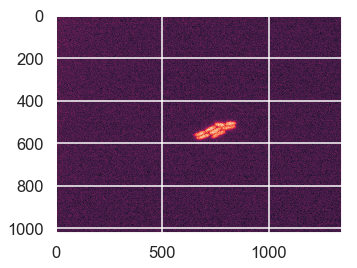

In [105]:
# Plot the image. 
plt.imshow(im)

We can see a small cluster of cells in the middle of the image. While we can easily tell what is cell and what is not, how do we make the computer see it? We can see that the bacteria seem brighter than the background. In terms of pixels, that means that the cells have a higher average pixel value than the background. 

To figure out what this average value is, we can look at the histogram of the image. We'll plot the data into 1000 bins ranging the width of our bit depth. 

Text(0, 0.5, 'number of observations')

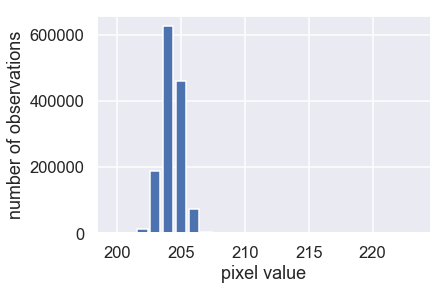

In [106]:
# Generate the image histogram
counts, bins = skimage.exposure.histogram(im)

# Plot it as a bar plot
plt.bar(bins, counts)

# Add appropriate labels.
plt.xlabel('pixel value')
plt.ylabel('number of observations')

We see a singluar peak around 205. While we may be tempted to say that is our bacterium, we have to remember that the y-axis here is abundance and in our image, background pixels are the most abundant. Since the cells represent a minor portion of our image, it makes more sense to plot thie histogram on a log scale. 

Text(0, 0.5, 'number of observations')

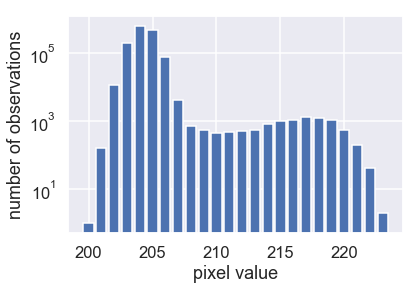

In [107]:
# Plot the same histogram but in log scale. 
plt.bar(bins, counts)
plt.yscale('log')

# Add appropriate labels
plt.xlabel('pixel value')
plt.ylabel('number of observations')

Here, we see two distinct values. By eye, we can draw a threshold of aound 210 - 211 counts as that which separates bacteria from background. 

We can apply this threshold to our image through a boolean comparison. By thresholding, we'll make a new image where all pixels greater than or equal to 210 are marked as True and all others are False 

In [108]:
# Threshold the image.
im_thresh = im >= 208
im_thresh

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

We see that we've generated an array of `False` and some `True`'s. We can plot this boolean image and it will interpreted as `True` being `1.0` and `False` being `0.0`.

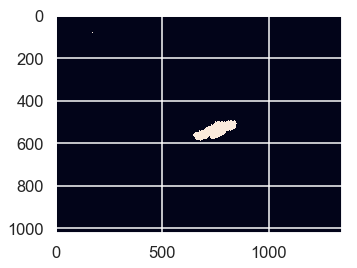

In [109]:
# Plot the thresholded image. 
plt.imshow(im_thresh)

It looks like that threshold does a pretty great job of identifying the bacteria! But what about the area? We can get the area of the bacterial mass by just summing the image. Since all `False` values are 0, by summing, we are adding only the pixels that are deemed as bacterial.

In [110]:
# Find the bacterial area in this frame. 
area = np.sum(im_thresh)
print('The bacterium is ' + str(area) + ' pixels.')

The bacterium is 10523 pixels.


It seems like a way to get the area. Since this seems like it works, we'll take this opportunity to write it as a function that we'll be able to apply to each image individually. 

In [111]:
def find_area(image, threshold_value):
    # Apply the threshold
    im_thresh = image >= threshold_value
    
    # Compute the area
    cell_area = np.sum(im_thresh)
    return cell_area

We can test out this function to make sure we get the same area as we did before. 

In [112]:
# Test out the function. 
cell_area = find_area(im, 208)
print(cell_area)

10523


Great! We get the same area whether we use the function or code it by hand. To get the area of each image, we'll loop through all of the files, read the image, pass it into our function, and store the area at that frame.  

In [113]:
# Set up an empty vector to store the measured area
cell_area = np.zeros(len(files))

# Loop through the files. 
for i in range(len(files)):
    
    # Load the image.
    im = skimage.io.imread(files[i])
    
    # Compute the area and sotre it in our vector. 
    cell_area[i] = find_area(im, 208)


With the images processed, we can now plot the area as a function of time. I know (since I took this data), that the frames were taken 5 minutes apart. First, we'll make a vector of time that is the same length as our file list, but has dimensions of time.   

Text(0, 0.5, 'cell area [pixels]')

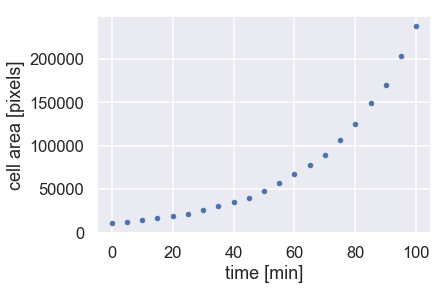

In [114]:
# Define the time vector
time_range = np.arange(0, len(files)) * 5 

# Plot the area vs time. 
plt.plot(time_range, cell_area, '.')

# Add appropriate labels.
plt.xlabel('time [min]')
plt.ylabel('cell area [pixels]')

Wow! That seems to be pretty exponential! In just a few lines of Python code, we were able to measure the growth of real-live bacterial cells! 

##  Determining the Growth Rate

While the plot looks nice, we can't really get a good measure of the growth rate just from looking at it. To determine the growth rate, we will need to do some rudimentary curve fitting. 

How would you define the line of best fit? If I were to ask you to draw the best fit line on this data, you would try to draw a line that is as close as possible to all of the points. Mathematically, what you are saying is you want to minimize the difference between the data and the best fit line across all measured data points. These differences, called "residuals", can be positive or negative. To minimize the residuals across all data points, we will sum the square of the residuals. This is often called the Chi-squared statistic and can be written as

$$
\chi^2 = \sum \limits_i^n (A(t)_i - A(t)_\text{theory})^2 \tag{3}
$$
where $n$ is the number of data points and $A(t)_\text{theory}$ is the expected cellular area at time $t$, given by our model of exponential growth. While there are many software packages to execute this type of regression, I find it more pedagogical to do so by hand. 

To do this regression, we'll set up a range of values for the growth rate. We'll then iterate through each one, compute the $\chi^2$ statistic and then plot it as a function of the growth rate. We should see a valley at the best-fit value.

Text(0, 0.5, '$\\chi^2$')

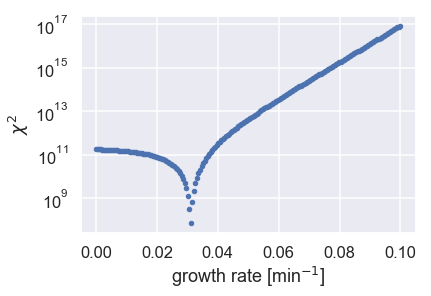

In [115]:
# Define the range of growth rates. 
r_range = np.linspace(0, 0.1, 200) # Choose 500 points

# Set up an empty vector to store the chi squared value
chi_sq = np.zeros(len(r_range))

# Iterate through each possible growth rate. 
for i in range(len(r_range)):
    # Compute the theoretical value at each time point. 
    theo = cell_area[0] * np.exp(r_range[i] * time_range)
    
    # Compute the sum squared residuals. 
    chi_sq[i] = np.sum((cell_area - theo)**2)
    
# Plot the chisq statistic
plt.plot(r_range, chi_sq, '.')
plt.yscale('log')

# Add appropriate labels
plt.xlabel('growth rate [min$^{-1}$]')
plt.ylabel('$\chi^2$')

There appears to be a very sharp peak right around 0.03 min$^{-1}$. We can find the exact value from this plot by indexing the `r_range` vector at the point where `chi_sq` is minimized. This index can be founding using `np.argmax` function in Numpy.

In [116]:
# Find the minimum of the chi_sq. 
min_ind = np.argmin(chi_sq)
best_r = r_range[min_ind]
print('The index at the minimum is ' + str(best_r) + ' min^-1.')

The index at the minimum is 0.031155778894472366 min^-1.


While that is obviously reporting too many significant digits, let's use this value to compute and plot the best fit line.  

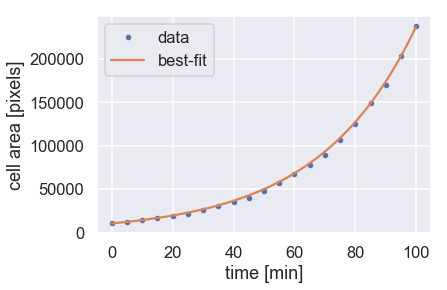

In [117]:
# Compute the best fit
t = np.linspace(0, 100, 500)
A_t = cell_area[0] * np.exp(best_r * t)

# Plot the elements
plt.plot(time_range, cell_area, '.', label='data')
plt.plot(t, A_t, '-', label='best-fit')

# Add appropriate labels and legend
plt.xlabel('time [min]')
plt.ylabel('cell area [pixels]')
plt.legend()


That seems like a pretty good fit. Now that we know the growth rate, we can compute the doubling time, which is a bit easier to think about. The doubling time is defined as the time at which $A(t) / A_0 = 2$,

$$
{A(t) \over A_0} = 2 = e^{rt} \tag{4}.
$$

Solving for $t$ yields

$$
t = {\ln 2 \over r}. \tag{5}
$$

With our best-fit growth rate, the doubling time comes out to be approximately 23 minutes, which is exactly what we would expect from *E. coli* growing on rich medium.

## In Conclusion... 

We covered a lot in this tutorial. We learned 1) how to do some basic image processing to identify objects in an image and 2) how to then fit a parameter to experimental data. While we have (hopefully) learned a lot from these two feats, it's important to realize that we have just scratched the surface. Object recognition and segmentation is a field that is still very much developing and there are ways to improve what we did here. 

While plotting the $\chi^2$ statistic is useful pedagogically, this becomes far more complicated if you are fitting more than one parameter. Furthermore, your model of interest may have many local minima that you may misidentify as the best-fit parameter value. When you inevitably do regression in your "real-life" research, you should be aware of these issues and use an appropriate algorithm.